In [2]:
import pandas as pd

# Load the cleaned dataset
data_clean = pd.read_csv('../data/processed/cleaned_heart_data.csv')



In [3]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import shap

# Separate features (X) and target (y)
y = data_clean['HeartDisease']
X = data_clean.drop('HeartDisease', axis=1)


/opt/miniconda3/envs/sehroz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


In [4]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
#baseline - 'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBP', 'RestingECG'
#stress test - 'MaxHR', 'Oldpeak', 'ExerciseAngina', 'ST_Slope'

#Age and Sex are in all three subsets

# Baseline features
X_train1 = X_train.drop(columns=['MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'])

# Stress test features
X_train2 = X_train.drop(columns=['ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 
                                'RestingBP', 'Cholesterol', 'FastingBS', 
                                'RestingECG_Normal', 'RestingECG_ST'])

# All features
X_train3 = X_train


In [10]:
X_test1 = X_test.drop(columns=['MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'])

X_test2 = X_test.drop(columns=['ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 
                              'RestingBP', 'Cholesterol', 'FastingBS', 
                              'RestingECG_Normal', 'RestingECG_ST'])

X_test3 = X_test

In [12]:
num_features1 = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS']
cat_features1 = ['Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 
                 'RestingECG_Normal', 'RestingECG_ST']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features1),
        ('cat', OneHotEncoder(), cat_features1)
    ],
    remainder='passthrough'
)

# Define models and parameters for grid search
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=2000)
}

params = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10, 100]},
    'Random Forest': {'classifier__n_estimators': [10, 50, 100], 'classifier__max_depth': [None, 10, 20, 30]},
    'Neural Network': {'classifier__hidden_layer_sizes': [(50,), (100,), (100, 100)], 'classifier__alpha': [0.0001, 0.001, 0.01]} 
}

best_model = None
best_params = None
best_score = 0
best_model_name = ""

# Perform grid search
for model_name in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models[model_name])
    ])
    
    grid = GridSearchCV(estimator=pipeline, param_grid=params[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train1, y_train)
    
    score = grid.best_score_
    if score > best_score:
        best_score = score
        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_model_name = model_name

# Test best model on the test set
y_pred = best_model.predict(X_test1)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Validation Accuracy: {best_score:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


/opt/miniconda3/envs/sehroz/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/sehroz/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/sehroz/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/sehroz/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/

Best Model: Random Forest
Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}
Validation Accuracy: 0.7652
Test Accuracy: 0.7867


/opt/miniconda3/envs/sehroz/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
num_features2 = ['Age', 'MaxHR', 'Oldpeak']
cat_features2 = ['Sex_M', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features2),
        ('cat', OneHotEncoder(), cat_features2)
    ],
    remainder='passthrough'
)

# Define models and parameters for grid search
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=2000)
}

params = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10, 100]},
    'Random Forest': {'classifier__n_estimators': [10, 50, 100], 'classifier__max_depth': [None, 10, 20, 30]},
    'Neural Network': {'classifier__hidden_layer_sizes': [(50,), (100,), (100, 100)], 'classifier__alpha': [0.0001, 0.001, 0.01]} 
}

best_model = None
best_params = None
best_score = 0
best_model_name = ""

# Perform grid search
for model_name in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models[model_name])
    ])
    
    grid = GridSearchCV(estimator=pipeline, param_grid=params[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train2, y_train)
    
    score = grid.best_score_
    if score > best_score:
        best_score = score
        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_model_name = model_name

# Test best model on the test set
y_pred = best_model.predict(X_test2)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Validation Accuracy: {best_score:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


/opt/miniconda3/envs/sehroz/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Model: Neural Network
Best Parameters: {'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50,)}
Validation Accuracy: 0.8406
Test Accuracy: 0.8600


In [20]:
num_features3 = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
cat_features3 = ['Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
               'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 
               'ST_Slope_Flat', 'ST_Slope_Up']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features3),
        ('cat', OneHotEncoder(), cat_features3)
    ],
    remainder='passthrough'
)

# Define models and parameters for grid search
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=2000)
}

params = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10, 100]},
    'Random Forest': {'classifier__n_estimators': [10, 50, 100], 'classifier__max_depth': [None, 10, 20, 30]},
    'Neural Network': {'classifier__hidden_layer_sizes': [(50,), (100,), (100, 100)], 'classifier__alpha': [0.0001, 0.001, 0.01]} 
}

best_model = None
best_params = None
best_score = 0
best_model_name = ""

# Perform grid search
for model_name in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models[model_name])
    ])
    
    grid = GridSearchCV(estimator=pipeline, param_grid=params[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train3, y_train)
    
    score = grid.best_score_
    if score > best_score:
        best_score = score
        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_model_name = model_name

# Test best model on the test set
y_pred = best_model.predict(X_test3)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Validation Accuracy: {best_score:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Best Model: Random Forest
Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}
Validation Accuracy: 0.8591
Test Accuracy: 0.9067


Shape of SHAP values: (596, 24, 2)
Shape of Transformed Data: (596, 24)
SHAP Values for Class 1 Shape: (24, 2)
Feature Names Length: 24
Corrected SHAP Values Shape: (596, 24)
X_train Shape: (596, 24)
Feature Names Length: 24


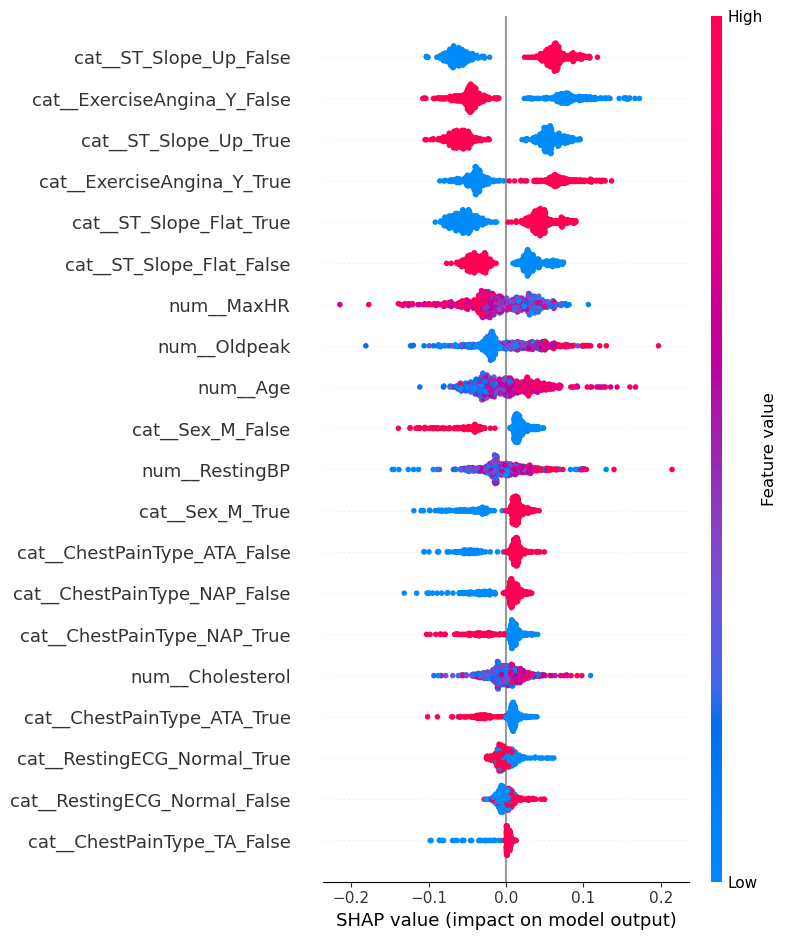

In [33]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Switch classifier to Random Forest
model = RandomForestClassifier()
pipeline = Pipeline([
   ('preprocessor', preprocessor),
   ('classifier', model)
])

# Fit pipeline
pipeline.fit(X_train, y_train)

# Get SHAP values
model = pipeline.named_steps['classifier']
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)
shap_values_class_1 = shap_values[1]

print("Shape of SHAP values:", np.array(shap_values).shape)
print("Shape of Transformed Data:", X_train_transformed.shape)
print("SHAP Values for Class 1 Shape:", shap_values_class_1.shape)
print("Feature Names Length:", len(feature_names))

# Fix shape issue with SHAP values
shap_values_class_1 = shap_values[:, :, 1]  # Correct indexing for class 1

print("Corrected SHAP Values Shape:", shap_values_class_1.shape)
print("X_train Shape:", X_train_transformed.shape)
print("Feature Names Length:", len(feature_names))

plt.figure(figsize=(10,8))
shap.summary_plot(shap_values_class_1, X_train_transformed, feature_names=feature_names)

In [34]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex_M', 'ChestPainType_ATA',
                                                   'ChestPainType_NAP',
                                                   'ChestPainType_TA',
                                                   'RestingECG_Normal',
                                                   'RestingECG_ST',
                                                   'ExerciseAngina_Y',
                                                   'ST_Slope_Flat',
                                                   'ST_Slope_Up'])])),
                ('classifier', RandomForestClassifier())])

In [35]:
feature_names = X_test.columns
print("Feature Names:", feature_names)

Feature Names: Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')


In [36]:
importances = model.feature_importances_

# Print the feature importances
print("Feature Importances:", importances)

Feature Importances: [0.07671535 0.0750056  0.07284646 0.00958777 0.09125428 0.07720851
 0.02252906 0.01973812 0.0209292  0.01499247 0.01684577 0.01602168
 0.00989508 0.00998801 0.01129942 0.01240816 0.00865271 0.00873386
 0.07934571 0.0637223  0.04978004 0.0740135  0.08276532 0.07572161]


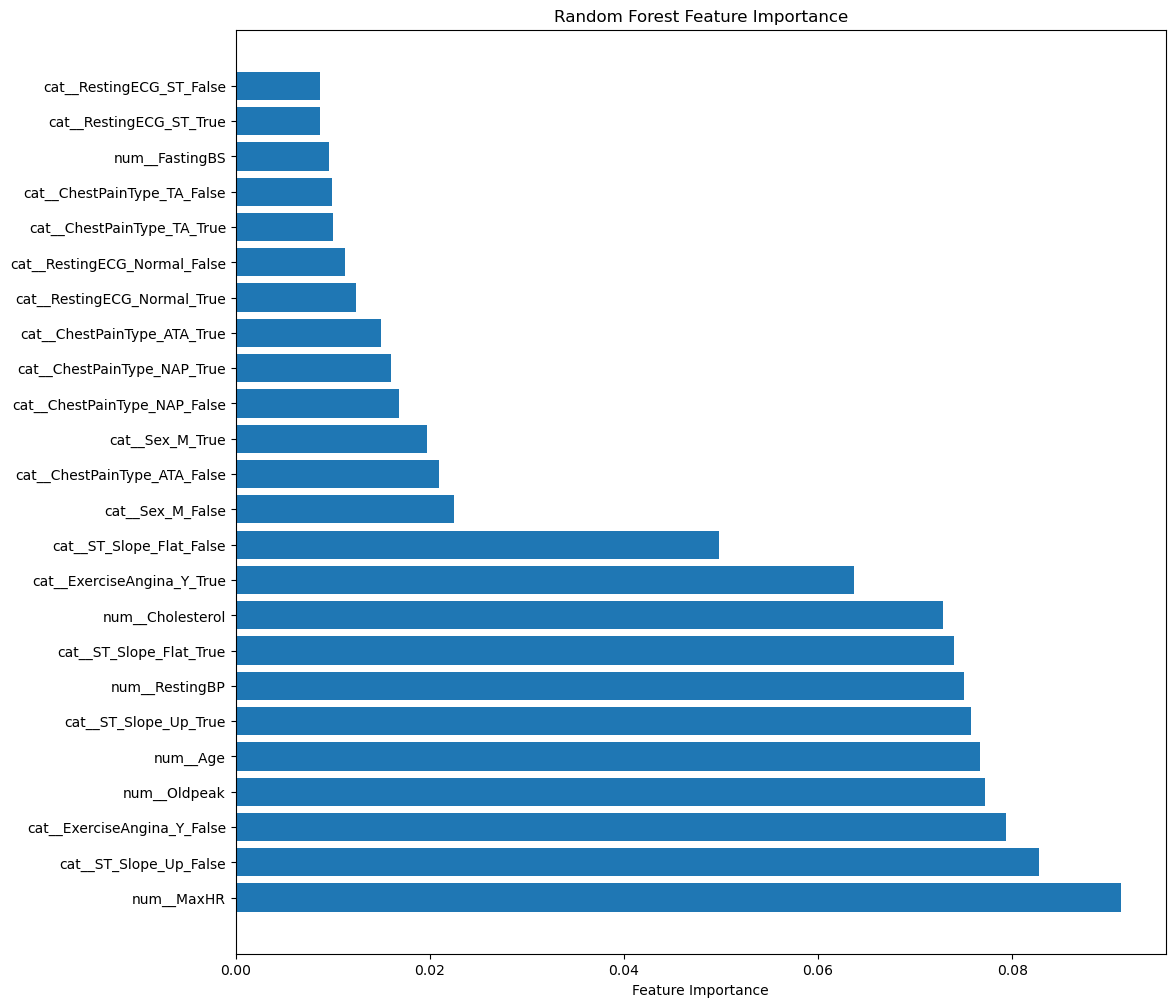

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `importances` comes from the feature importances of a trained RandomForest model
# For example: importances = model.feature_importances_

# If `X` has been preprocessed, make sure you use the transformed feature names
# Get feature names from the model's pipeline or from preprocessor if it's been applied
# This step may differ based on your setup, here’s an example:
try:
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Sort the importances in descending order
sorted_idx = np.argsort(importances)[::-1]

# Create the plot
plt.figure(figsize=(12, 12))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), np.array(feature_names)[sorted_idx])  # Ensure feature_names match importances length
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()
